# Affine Gap Penalties

Instead of linear gap penalties, we can modify gap penalties such that an opening gap is taxed more heavily than an extended gap.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import sequence_alignment as seq

In [2]:
seq_2 = "KKASKASPKKKK"
seq_1 = "KKSPKMLHKK"

## 1. Initialization

When working with affine gap penalties we have two gap penalty values — one for opening up a gap and one for extending a gap. Therefore the initialized scoring matrix ($M$) is different from the linear gap penalty case.

In [3]:
g_open = -6; g_ext = -2

In [4]:
m = len(seq_1); n = len(seq_2)
M = np.zeros([m+1,n+1])
#initialize the matrix
M[0,1:] = g_open + g_ext*np.arange(0,n,1)
M[1:,0] = g_open + g_ext*np.arange(0,m,1)

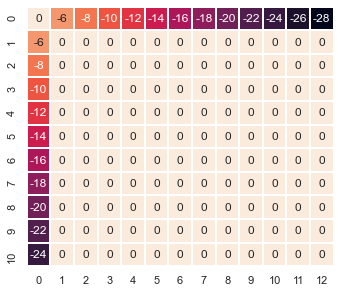

In [5]:
plt.figure(figsize=(5.5,5.5))
sns.heatmap(M,linecolor='white',linewidth=1,square=True,annot=True,cbar=False);

For implementing global dynamic programming with affine gap penalties, we need to introduce two 'helper' scoring matrices, let's call them $U$ and $L$. These matrices have to be initialized in a slightly different fashion from $M$.

In [6]:
#initialize helpers
L = np.copy(M); U = np.copy(M)
L[1:,0] = L[1:,0]+g_open; U[0,1:] = U[0,1:]+g_open #avoiding Gotoh's error (see reference 2.)

## 2. Fill Step

To fill the matrix with scores, we need to iterate over the elements of the matrix and fill in values according to the following recursive relations:

$$
L_{i,j} = \max \{ (U_{i,j-1} + g_{ext}), \ (M_{i,j-1} + g_{open)} \}
$$ 
<br>
$$
L_{i,j} = \max \{ (L_{i-1,j} + g_{ext}), \ (M_{i-1,j} + g_{open)} \}
$$
<br>
$$
M_{i,j} = \max \{ (M_{i-1,j-1} + S_{i,j}), \ L_{i,j}, \ U_{i,j} \}
$$

Where $M$ is the scoring matrix, $S$ is the substitution matrix, $g_{open}$ is the opening gap penalty, $g_{ext}$ is the extension gap penalty and $U$, $L$ are the upper and leftward 'helper' matrices.

### Substitution Matrix

We will use the BLOSUM62 matrix for obtaining substitution scores for protein sequences.

In [7]:
S = pd.read_csv('blosum62.csv',index_col=0)

### Filling up the $\text{M}, \text{U}$ and $\text{L}$ matrices

In [8]:
#initialize tracer
tracer = np.zeros([np.shape(M)[0],np.shape(M)[1],7])

for i in range(1,m+1):
    for j in range(1,n+1):
        l_arr = np.array([M[i,j-1]+g_open,L[i,j-1]+g_ext])
        L[i,j] = np.max(l_arr)
        l_where = l_arr==np.max(l_arr)
                        
        u_arr = np.array([M[i-1,j]+g_open,U[i-1,j]+g_ext])
        U[i,j] = np.max(u_arr)
        u_where = u_arr==np.max(u_arr)
                        
        m_arr = np.array([M[i-1,j-1]+(S[seq_1[i-1]][seq_2[j-1]]),U[i,j],L[i,j]])
        M[i,j] = np.max(m_arr)
        m_where = m_arr==np.max(m_arr)
            
        idx = np.hstack([m_where,u_where,l_where])
        tracer[i,j,idx] = 1

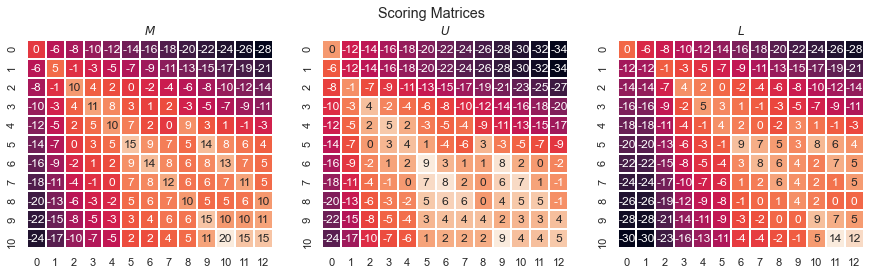

In [9]:
fig, ax = plt.subplots(1,3,figsize = (15,4))
for i,p in enumerate([[M,"$M$"],[U,"$U$"],[L,"$L$"]]):
    sns.heatmap(p[0],linecolor='white',linewidth=1,square=True,annot=True,cbar=False,ax=ax[i]);
    ax[i].set_title(p[1])
fig.suptitle("Scoring Matrices");

## 3. Traceback
The 3D `tracer` matrix saves the tracebacks as shown below — with each sub-matrix corresponding to a particular movement. In the affine gap penalty case, arrows can indicate movement _between_ the scoring matrices shown above.

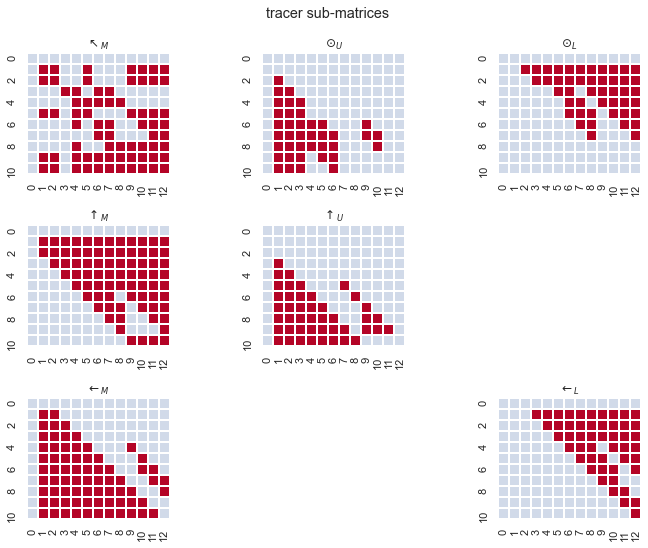

In [10]:
fig, ax = plt.subplots(3,3,figsize = (10,8))

for i,m in enumerate([[0,0,r"$\nwarrow_{M}$"],[0,1,r"$\odot_{U}$"],[0,2,r"$\odot_{L}$"],
                      [1,0,r"$\uparrow_{M}$"],[1,1,r"$\uparrow_{U}$"],
                      [2,0,r"$\leftarrow_{M}$"],[2,2,r"$\leftarrow_{L}$"]]):
    sns.heatmap(tracer[:,:,i],cmap="coolwarm",vmin=-0.5,vmax=0.6,linecolor='white',
                linewidth=1,square=True,cbar=False,ax=ax[m[0]][m[1]])
    ax[m[0]][m[1]].set_title(m[2])

fig.delaxes(ax[1][2]); fig.delaxes(ax[2][1])
fig.suptitle("tracer sub-matrices")
fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

$\nwarrow_\text{M}$ indicates movement along the $\text{M}$ matrix in the diagonal direction,
$\odot_\text{U}$ indicates climbing up to the $\text{U}$ matrix and $\odot_\text{L}$ indicates climbing down to the $\text{L}$ matrix. $\leftarrow_\text{M}$ indicates first hopping onto $\text{M}$ and then moving diagonally. Similarly, $\leftarrow_\text{L}$, $\uparrow_\text{M}$ and $\uparrow_\text{U}$ indicate how to move and on which matrix.

Thus the `tracer` matrix in the affine gap penalty case has 7 sub-matrices as opposed to 3 in this implementation. This can be avoided by storing different symbols within the same matric as opposed to having a sub-matrix for each symbol. 

### Calling the traceback function

We can therefore call the `traceback_iterator` function with `affine = True` which in turn calls the `affine_traceback` function on the `tracer` matrix to generate the alignments.

In [11]:
alignment = seq.traceback_iterator(tracer,seq_1,seq_2,affine=True,high_low=True)
for i,e in enumerate(alignment):
    print(str(i+1)+".","\n",e[0],"\n",e[1],"\n")

1. 
 KK----SPKMLHKK 
 KKASKASPK--KKK 

2. 
 KK----SPKMLHKK 
 KKASKASPKK--KK 



Therefore, there are at least two optimal solutions for the above pair of sequences with the maximum score = +15.

## 4. Example Alignments

We can try out a few sequence alignments to see if this implementation leads to expected results. <br>

### Protein Sequences

### 1.1

In [12]:
seq_2 = "KKASKASPKKKK"
seq_1 = "KKSPKMLHKK"
g_open = -6; g_ext = -6

_,_,_,_,_, = seq.affine_global_dp(seq_1,seq_2,S,g_open,g_ext,
                                  disp_alignments=True,max_i=200)

Max. score = 9.0
1. 
 KKSPK-M-LHKK 
 KKASKASPKKKK 

2. 
 KKSPKM--LHKK 
 KKASKASPKKKK 

3. 
 KKSPKML-H-KK 
 KKASKASPKKKK 

4. 
 KKSPKML-HK-K 
 KKASKASPKKKK 

5. 
 KKSPKML-HKK- 
 KKASKASPKKKK 

6. 
 KKSPKML--HKK 
 KKASKASPKKKK 



### Affine vs. Linear Alignment

We should expect that for equal costs of gap opening and extension, affine penalties should reduce to linear penalties. In **example 1.1** we called the `seq.affine_global_dp` function with $g_{open} = g_{ext} = -6$. In **1.2**, we will call the `seq.global_dp` function with $g = -6$ for the same pair of sequences.

### 1.2

In [13]:
_,_,_ = seq.global_dp(seq_1,seq_2,S,-6,
                                  disp_alignments=True,max_i=200)

Max. score = 9.0
1. 
 KKSPK-M-LHKK 
 KKASKASPKKKK 

2. 
 KKSPKM--LHKK 
 KKASKASPKKKK 

3. 
 KKSPKML-H-KK 
 KKASKASPKKKK 

4. 
 KKSPKML-HK-K 
 KKASKASPKKKK 

5. 
 KKSPKML-HKK- 
 KKASKASPKKKK 

6. 
 KKSPKML--HKK 
 KKASKASPKKKK 



### 2.

In [14]:
seq_2 = "KMNKPLQRTS"
seq_1 = "KMNKPSQRTTTS"
g_open = -5; g_ext = -1

_,_,_,_,_, = seq.affine_global_dp(seq_1,seq_2,S,g_open,g_ext,
                                  disp_alignments=True)

Max. score = 39.0
1. 
 KMNKPSQRTTTS 
 KMNKPLQR--TS 

2. 
 KMNKPSQRTTTS 
 KMNKPLQRT--S 



### DNA Sequences

We choose pairs of sequences for which all optimal alignments have been described in the literature.

### 1.

In [15]:
seq_2 = "AAAGGG"
seq_1 = "TTAAAAGGGGTT"
g_open = -6; g_ext = -1
S = pd.read_csv('dna_identity.csv',index_col=0)
S[S==0] = -1
S[S==1] = 0
_,_,_,_,_, = seq.affine_global_dp(seq_1,seq_2,S,g_open,g_ext,
                                  disp_alignments=True)

Max. score = -15.0
1. 
 TTAAAAGGGGTT 
 AAA------GGG 



### 2.

In [16]:
seq_2 = "AGT"
seq_1 = "TGAGTT"
g_open = -2; g_ext = -1
S = pd.read_csv('dna_identity.csv',index_col=0)
S[S==0] = -1
S[S==1] = 0

_,_,_,_,_, = seq.affine_global_dp(seq_1,seq_2,S,g_open,g_ext,
                                  disp_alignments=True)

Max. score = -5.0
1. 
 TGAGTT 
 AG---T 

2. 
 TGAGTT 
 --AGT- 

3. 
 TGAGTT 
 --AG-T 



### 3.

In [17]:
seq_1 = "TAAATTTGC"
seq_2 = "TCGCCTTAC"
g_open = -41; g_ext = -1
S = pd.read_csv('dna_identity.csv',index_col=0)
S[S==0] = -30
S[S==1] = 10

_,_,_,_,_ = seq.affine_global_dp(seq_1,seq_2,S,g_open,g_ext,
                                  disp_alignments=True)

Max. score = -62.0
1. 
 T------AAATTTGC 
 TCGCCTTA------C 

2. 
 ------TAAATTTGC 
 TCGCCTTA------C 



### 4.

In [18]:
seq_1 = "CC"
seq_2 = "ACCT"
g_open = -5; g_ext = -1
S = pd.read_csv('dna_identity.csv',index_col=0)
S[S==0] = -1
S[S==1] = 0

_,_,_,_,_ = seq.affine_global_dp(seq_1,seq_2,S,g_open,g_ext,
                                  disp_alignments=True)

Max. score = -7.0
1. 
 CC-- 
 ACCT 

2. 
 --CC 
 ACCT 

